In [1]:
import sys
import os
sys.path.append(os.path.abspath("../clean_code"))

In [2]:
import numpy as np
from typing import Union, Optional, List, Any, Tuple, Callable, Dict
from itertools import product
import pandas
import matplotlib.pyplot as plt
import random

from scipy.sparse.linalg import cg
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.datasets import fetch_openml
from scipy.optimize import minimize

import importlib

import landmark
import voltagemap
import problem
import solver
import visualization
import setofpoints
import kmeans
import config

In [23]:
importlib.reload(solver)

<module 'solver' from '/home/avighna/Documents/python/VoltageDimentionalReduction/clean_code/solver.py'>

In [3]:
print("Streaming K-means on MNIST dataset")

config.params['file_path']= '../data/mnist.csv'
config.params['split_char']= ','
config.params['normalize_vecs']= False
config.params['max_centroids']= 1000
config.params['init_size']= 1000
config.params['batch_size']= 10000
config.params['output']= 'streaming_centroids.npy'

centroids,counters,inital_mean_d2,mean_d2=kmeans.Streaming_Kmeans(config.params['file_path'])

X = np.stack(centroids)
print('X.shape=',X.shape)

# Normalize pixel values to [0, 1]
X = X / 255.0
y = 0 # just a patch to make things run, as we do not use labels in this example

Streaming K-means on MNIST dataset
Read 10000 vectors
Estimated max pairwise distance squared, FAISS) = 14421172.0000
 Estimated minimum distance squared = 89648.0000
10 vectors in index after adding initial centroid
Read 20000 vectors
number of centroids: 1000, max_centroids: 1000
Reached maximum number of centroids: 1000
Read 60000 vectorsmean d2= 1687996.0037312534
Closing reader...
X.shape= (1000, 784)


In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X2, y2 = mnist.data, mnist.target.astype(np.int64)

# Normalize pixel values to [0, 1]
X2 = X2 / 255.0

X2 = X2[:1000]
y2 = y2[:1000]

In [27]:
#av: TODO replace compressed_set with point_set
# define set of points on which we will work
point_set = setofpoints.SetOfPoints(points=X)

#av: TODO choose landmarks randoomly or greeedily
# Special for MNist : 
# Select one sample per digit to serve as a landmark
landmarks = []

for digit in range(10):
    landmarks.append(landmark.Landmark(random.randint(0, centroids.shape[0]),1.0))

mnist_problem = problem.Problem(point_set, r=1)
mnist_solver = solver.Solver(mnist_problem)

mnist_problem.optimize(landmarks, k=4, target_avg_voltage=0.5)

10
10
10
10
10
10
10
10
10
10
10


In [6]:
# Initialize the map
voltage_map = voltagemap.VoltageMap()

# Compute voltages for each landmark and store in the map
for lm in landmarks:
    mnist_solver = solver.Solver(problem=mnist_problem)
    voltages = mnist_solver.compute_voltages(k=2, landmarks=[lm])
    voltage_map.add_solution(landmark_index=lm.index, voltages=voltages)

print(np.array(voltage_map.voltage_maps).shape)

(12, 1000)


In [7]:
def get_distinct_colors(N):
    def inverse_pairwise_squared_distance_sum(points):
        n_points = points.shape[0]
        dist_sum = 0.0
        for i in range(n_points):
            for j in range(i + 1, n_points):
                dist_sum += 1.0 / (np.sum((points[i] - points[j]) ** 2) + 10 ** (-len(points)))
        return dist_sum
    
    def objective(x, n):
        points = x.reshape((n, 3))
        # Add the origin manually
        all_points = np.vstack(([0, 0, 0], points))
        return inverse_pairwise_squared_distance_sum(all_points)  # Negate for minimization
    
    # Initial guess: random points in unit cube
    init_points = np.random.rand(N, 3)
    result = minimize(
        objective,
        init_points.flatten(),
        args=(N,),
        method='L-BFGS-B',
        bounds=[(0, 1)] * (3 * N),
        options={'maxiter': 1000}
    )
    optimized_points = result.x.reshape((N, 3))
    return optimized_points

In [8]:
#av: TODO call some visualizations, that store the figure into a file.
def plot_mds_unlabeled(voltages, data, landmarkSize=3, alpha_actual=1, percent_size=0.02, out_file=None):
    """
    Draws the MNIST digits corresponding to each point after running MDS

    Args:
        selected_digits (List[int]): The digits to plot
        voltages (VoltageMap): The digits to plot
        data (SetOfPoints): The digits to plot
        correct (List[int]): The correct labels for each point in data
        n_outliers (Optional[int]): The number of outliers to remove
        alpha_actual (Optional[float]): The opacity of each digit, 1 is fully opaque and 0 is fully transparent
        percent_size (Optional[float]): The size of each digit, 1 is the size of the whole space and 0 is no image size
        out_file (Optional[str]): If provided, the output path to save the figure (e.g., "digits.png")
    """

    voltages = np.array(voltages.voltage_maps)
    points = np.array(list(map(list, zip(*voltages))))

    mds = MDS(n_components=2)
    transformed_points = mds.fit_transform(points)

    fig, ax = plt.subplots(figsize=(12, 10))

    colors = get_distinct_colors(voltages.shape[0])
    
    x_bound = (transformed_points[:, 0].min(), transformed_points[:, 0].max())
    y_bound = (transformed_points[:, 1].min(), transformed_points[:, 1].max())

    image_size = (x_bound[1] + y_bound[1] - x_bound[0] - y_bound[0]) * percent_size / 2
    
    for i in range(transformed_points.shape[0]):
        alpha_mask = np.clip(data[i].reshape(28, 28), 0, 1)

        point_voltages = voltages[:, i]
        
        color = np.array(colors[np.argmax(point_voltages)])

        size = 1
        if (np.max(point_voltages) == 1):
            size = landmarkSize
        
        # Create RGBA image
        rgb_image = np.zeros((28, 28, 4))
        for c in range(3):
            rgb_image[..., c] = color[c]
        rgb_image[..., 3] = alpha_mask * alpha_actual  # Alpha from pixel intensity

        x, y = transformed_points[i]
        ax.imshow(rgb_image, extent=(x - image_size * size, x + image_size * size, y - image_size * size, y + image_size * size), origin='upper')
    
    ax.set_xlim(x_bound[0] - image_size * landmarkSize, x_bound[1] + image_size * landmarkSize)
    ax.set_ylim(y_bound[0] - image_size * landmarkSize, y_bound[1] + image_size * landmarkSize)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    plt.title("MDS Visualization of K-Means MNIST")

    if out_file:
        plt.savefig(out_file)
        plt.close(fig)
    else:
        plt.show()

In [9]:
np.array(voltage_map.voltage_maps).shape

(12, 1000)

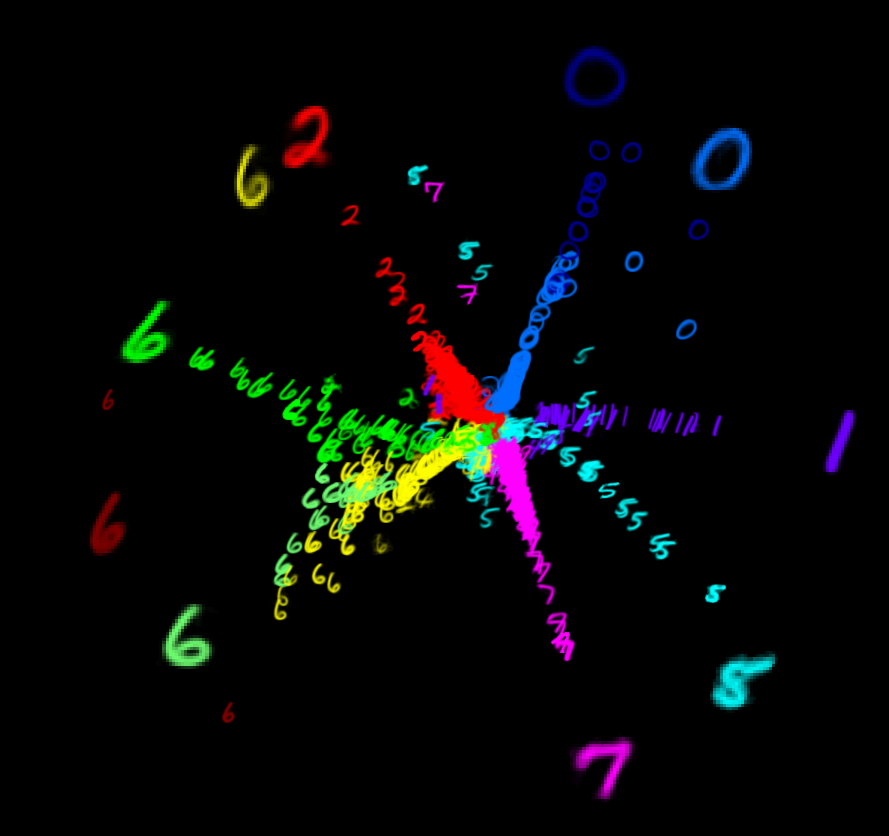

In [11]:
plot_mds_unlabeled(voltage_map, point_set, alpha_actual=1)